# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
%pylab inline 
import pickle 
import numpy as np
import cv2
from sklearn.utils import shuffle


Populating the interactive namespace from numpy and matplotlib


In [4]:
import os
os.chdir('../')

In [5]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = shuffle(train['features'], train['labels'])
X_valid, y_valid = shuffle(valid['features'], valid['labels'])
X_test, y_test = test['features'], test['labels']

In [6]:
import random
import pandas as pd

signames = pd.read_csv('signnames.csv', index_col=0)['SignName']

### Visualizing dataset
taking random pictures

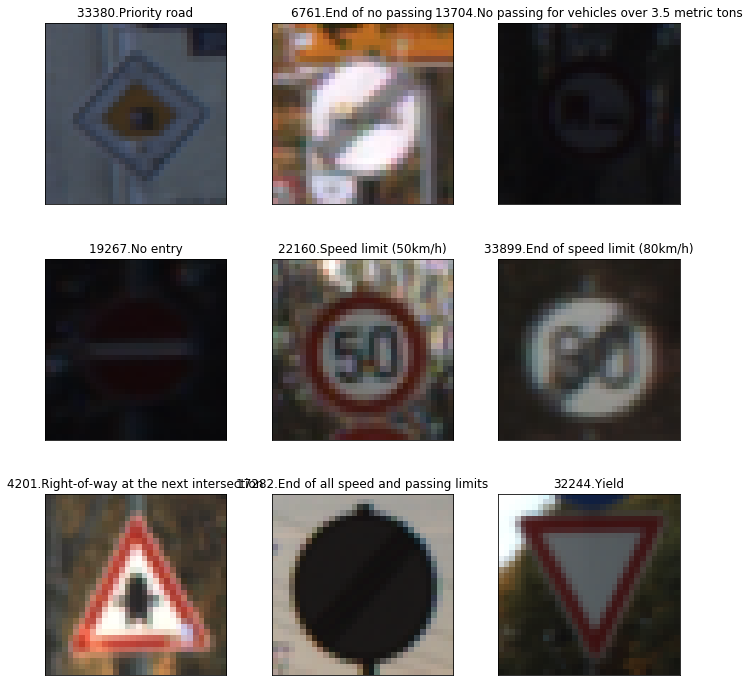

In [7]:
fig, axes = subplots(3, 3, figsize=(12, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)


random_idx = random.sample(range(len(X_train)), 9)

for ax, i in zip(axes.flat, random_idx):
    ax.imshow(X_train[i])
    ax.set_title(str(i) +'.' + signames[y_train[i]])
show()

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [8]:
from scipy.misc import imresize

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [10]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of validation examples
n_validation = y_valid.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]
n_valid = y_valid.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.max(y_train)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 42


### Include an exploratory visualization of the dataset

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [11]:
def normalize_picture(pic):
    ret = pic.astype(np.float32) * 1.0/255.
    return ret - 0.5

## Preprocessing all the data first

In [12]:
from sklearn.preprocessing import LabelBinarizer

In [13]:
label_binarizer = LabelBinarizer()
y_one_hot_train = label_binarizer.fit_transform(y_train)
y_one_hot_valid = label_binarizer.fit_transform(y_valid)
y_one_hot_test = label_binarizer.fit_transform(y_test)


### Model Architecture

LeNet

In [23]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from keras.models import Model
from keras.layers import Cropping2D, Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import Lambda, concatenate
from keras import initializers
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [15]:
def Dnn(in_layer):
    winit = initializers.TruncatedNormal(stddev=0.05)
    # 32x32x3
    conv = Conv2D(32, (3,3), padding='same', kernel_initializer=winit, activation='relu')(in_layer)
    # 32x32x48
    pool = MaxPooling2D((2,2))(conv)
    # 16x16x32
    conv = Conv2D(64, (3,3), padding='valid', kernel_initializer=winit, activation='relu')(pool)
    drop = Dropout(0.5)(conv)
    # 14x14x64
    pool = MaxPooling2D((2,2))(drop)
    # 7x7x64
    conv = Conv2D(128, (3,3), padding='valid', kernel_initializer=winit, activation='relu')(pool)
    # 5x5x128
    flat = Flatten()(conv)
    dense1 = Dense(256,activation='relu', kernel_initializer=winit)(flat)
    
    return dense1

In [24]:
def build_model():
    w = image_shape[1]
    h = image_shape[0]
    winit = initializers.TruncatedNormal(stddev=0.05)
    
    input_img = Input(shape=image_shape)
    
    norm = Lambda(lambda x: x/127.5 - 1.)(input_img)
    dnn = Dnn(norm)

    dense2 = Dense(1024,activation='relu', kernel_initializer=winit)(dnn)
    output_layer = Dense(43,activation='softmax')(dense2)
        
    model = Model(inputs=input_img, outputs=output_layer)
    return model

In [27]:
model = build_model()
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [28]:
history = model.fit(X_train, y_one_hot_train, 
                    epochs=50, verbose=2, batch_size=128,
                    validation_data=(X_valid, y_one_hot_valid),
                    callbacks=[
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=2),
                        EarlyStopping(monitor='val_loss', patience=20, verbose=2, min_delta=1e-03)])

Train on 34799 samples, validate on 4410 samples
Epoch 1/50
11s - loss: 0.9703 - acc: 0.7130 - val_loss: 0.4185 - val_acc: 0.8825
Epoch 2/50
11s - loss: 0.1468 - acc: 0.9546 - val_loss: 0.2895 - val_acc: 0.9125
Epoch 3/50
11s - loss: 0.0832 - acc: 0.9747 - val_loss: 0.2621 - val_acc: 0.9299
Epoch 4/50
11s - loss: 0.0573 - acc: 0.9825 - val_loss: 0.2695 - val_acc: 0.9211
Epoch 5/50
11s - loss: 0.0431 - acc: 0.9866 - val_loss: 0.2004 - val_acc: 0.9356
Epoch 6/50
11s - loss: 0.0387 - acc: 0.9882 - val_loss: 0.2289 - val_acc: 0.9395
Epoch 7/50
11s - loss: 0.0358 - acc: 0.9880 - val_loss: 0.2160 - val_acc: 0.9331
Epoch 8/50
10s - loss: 0.0370 - acc: 0.9885 - val_loss: 0.2161 - val_acc: 0.9358
Epoch 9/50

Epoch 00008: reducing learning rate to 0.00020000000949949026.
11s - loss: 0.0237 - acc: 0.9922 - val_loss: 0.2849 - val_acc: 0.9469
Epoch 10/50
10s - loss: 0.0080 - acc: 0.9978 - val_loss: 0.2194 - val_acc: 0.9626
Epoch 11/50
10s - loss: 0.0043 - acc: 0.9987 - val_loss: 0.2171 - val_acc: 0

In [ ]:
Beep(2500, 1000)

In [30]:
model.evaluate(X_test, y_one_hot_test)

12544/12630 [============================>.] - ETA: 0s

[0.22505946388376064, 0.95186064934220849]

Not the best accuracy, comparing to the [results](http://benchmark.ini.rub.de/?section=gtsrb&subsection=results#), but I expected worse.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

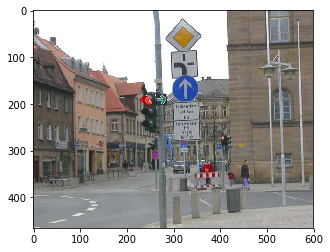

In [31]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

from urllib.request import urlretrieve
url = 'http://cdn.trendhunterstatic.com/thumbs/germany-traffic.jpeg'

urlretrieve(url, 'gt.jpg')

img = imread('gt.jpg')
imshow(img)

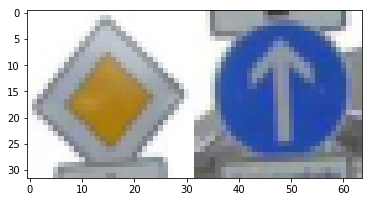

In [32]:
google_images = [imresize(img[15:95, 280:366], (32,32))]
google_images.append(imresize(img[135:205, 290:360], (32,32)))
imshow(np.hstack(google_images))

In [33]:
import os

In [34]:
# pictures are taken from the googlemaps service
dir_name = 'gmaps'
for filename in os.listdir(dir_name):
    img = imread(dir_name+'/'+filename)
    img = imresize(img, (32,32))
    google_images.append(img)
print(len(google_images))

12


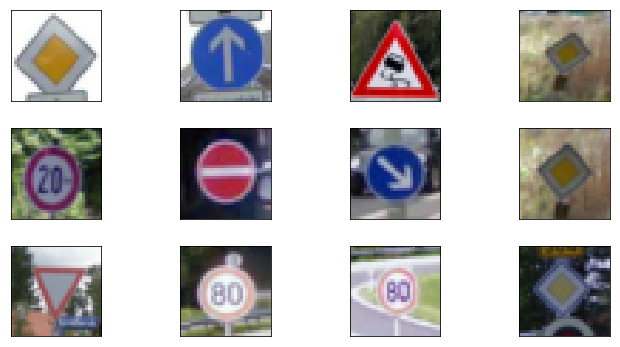

In [35]:
fig, axes = subplots(3, 4, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, img in zip(axes.flat, google_images):
    ax.imshow(img)
show()

### Predict the Sign Type for Each Image

In [36]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
X_i = np.array(google_images)
prediction = model.predict(X_i)

In [37]:
len(google_images)

12

In [38]:
# decoding sign number into sign name
def decode_sign(pred):
    top_5_args = np.argsort(pred)[-5:][::-1]
    top_5_prob = [pred[x] for x in top_5_args]
    top_5_label = [signames[x] for x in top_5_args]
    for sign in top_5_args:
            print("{:2} ({:.4}%): {}".format(sign, pred[sign]*100, signames[sign]))

In [39]:
Y_pred = [np.argsort(x)[-1] for x in prediction]

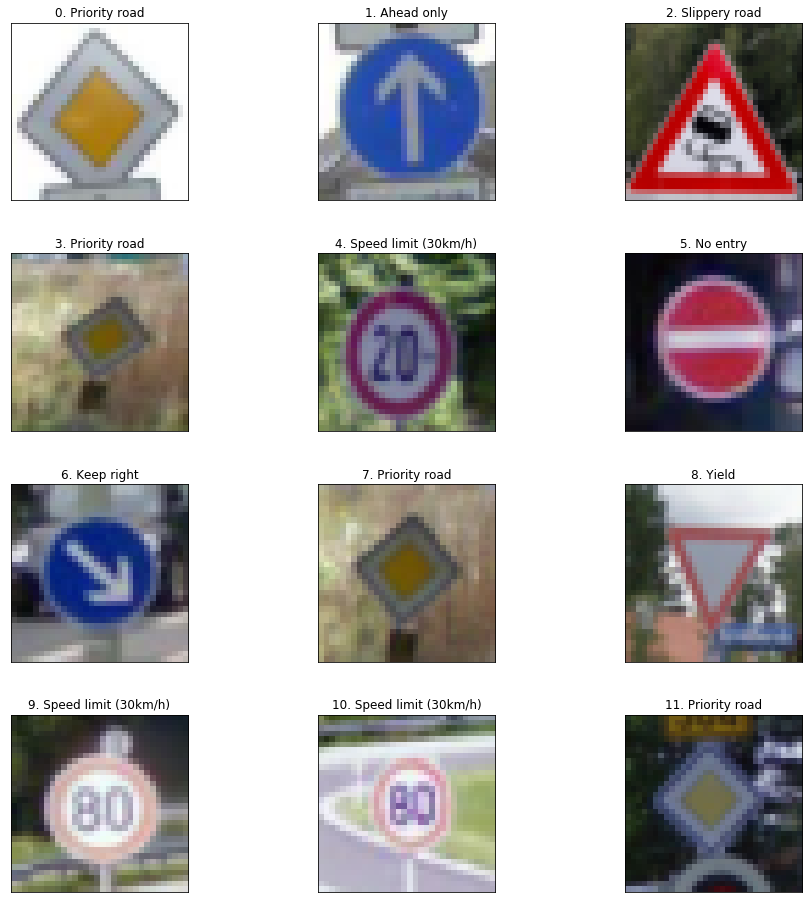

In [40]:
fig, axes = subplots(4, 3, figsize=(16, 16),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.1)

for i, (ax, img) in enumerate(zip(axes.flat, google_images)):
    ax.imshow(img)
    ax.set_title(str(i)+'. '+ signames[Y_pred[i]])
show()

### Let's look closer at the sign 10

 1 (97.15%): Speed limit (30km/h)
11 (1.83%): Right-of-way at the next intersection
42 (0.7271%): End of no passing by vehicles over 3.5 metric tons
 2 (0.1715%): Speed limit (50km/h)
 5 (0.02487%): Speed limit (80km/h)


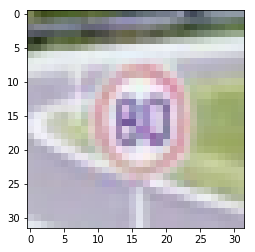

In [41]:
decode_sign(prediction[10])
imshow(google_images[10])

In [42]:
print(signames[0], ": train set has", np.count_nonzero(y_train == 0), " entries")
print(signames[1], ": train set has", np.count_nonzero(y_train == 1), " entries")
print(signames[7], ": train set has", np.count_nonzero(y_train == 7), " entries")

Speed limit (20km/h) : train set has 180  entries
Speed limit (30km/h) : train set has 1980  entries
Speed limit (100km/h) : train set has 1290  entries


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [43]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
for i, pred in enumerate(prediction):
    print("\nPicture N", i)
    decode_sign(pred)


Picture N 0
12 (100.0%): Priority road
10 (2.002e-07%): No passing for vehicles over 3.5 metric tons
14 (1.588e-08%): Stop
29 (1.581e-08%): Bicycles crossing
17 (5.262e-09%): No entry

Picture N 1
35 (100.0%): Ahead only
36 (1.586e-05%): Go straight or right
37 (5.714e-06%): Go straight or left
20 (1.654e-06%): Dangerous curve to the right
40 (6.683e-08%): Roundabout mandatory

Picture N 2
23 (100.0%): Slippery road
30 (1.332e-07%): Beware of ice/snow
19 (6.836e-09%): Dangerous curve to the left
21 (5.525e-09%): Double curve
31 (3.51e-11%): Wild animals crossing

Picture N 3
12 (99.93%): Priority road
11 (0.05634%): Right-of-way at the next intersection
42 (0.005227%): End of no passing by vehicles over 3.5 metric tons
26 (0.003692%): Traffic signals
41 (0.001608%): End of no passing

Picture N 4
 1 (43.77%): Speed limit (30km/h)
 8 (29.16%): Speed limit (120km/h)
 7 (24.2%): Speed limit (100km/h)
 0 (2.023%): Speed limit (20km/h)
40 (0.3874%): Roundabout mandatory

Picture N 5
17 (10